# Project \#3 - Face generation

### Deep Learning course -  A.Y. 2019-2020

Students:
- Simone Gayed Said
- Pierpasquale Colagrande


## Import of fundamental libraries
Herw we import fundamental libraries as TensorFlow, Numpy etc.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


In [0]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Flatten, Dense, Reshape, Concatenate, Lambda, Concatenate, Layer, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
import numpy as np
import matplotlib.pyplot as plt
import os


## Input pipeline

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 2025 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.


In [0]:
BATCH_SIZE = 128
BUFFER_SIZE = 60000
ORIGINAL_IMAGE_SIZE = (218, 178, 3)
TARGET_IMAGE_SIZE = (64, 64, 3)
INTERMEDIATE_SIZE = 3072
ATTRIBUTES_SIZE = 40
LATENT_DIM = 64

In [0]:
AUTO = tf.data.experimental.AUTOTUNE

gcs_pattern = 'gs://celeba-test/tfrecord_*.tfrec'

filenames = tf.io.gfile.glob(gcs_pattern)

def parse_attribute_list(example):
  features = {
      "names": tf.io.FixedLenFeature([], tf.string),
  }

  example = tf.io.parse_single_example(example, features)
  attributes_names = example['names']
  return attributes_names

def get_names():
  record = tf.data.TFRecordDataset('gs://celeba-test/attribute_list.tfrec')
  attributes = record.map(parse_attribute_list)
  att_names = next(attributes.as_numpy_iterator()).decode("utf-8")
  att_names_list = [elem.strip()[1:-1] for elem in att_names.split(',')]
  return att_names_list

att_names_list = get_names()

feature_dict = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "labels": tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
  }

def parse_tfrecord(example):
  features = feature_dict
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_image(example['image'])  
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [ORIGINAL_IMAGE_SIZE[0], ORIGINAL_IMAGE_SIZE[1], ORIGINAL_IMAGE_SIZE[2]])
  image_tensor = tf.image.resize(image_tensor[45:173,25:153], (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1])) # crop and reshape the image 
  labels = example['labels']
  labels = tf.cast(labels,tf.float32)
  return  {"encoder_input":image_tensor,"labels": labels}


def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)


all_dataset = load_dataset(filenames)

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):

  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTO)

  return ds

training_dataset = prepare_for_training(all_dataset)

Let's take a peek at the dataset we've created:

In [0]:
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.axis('off')

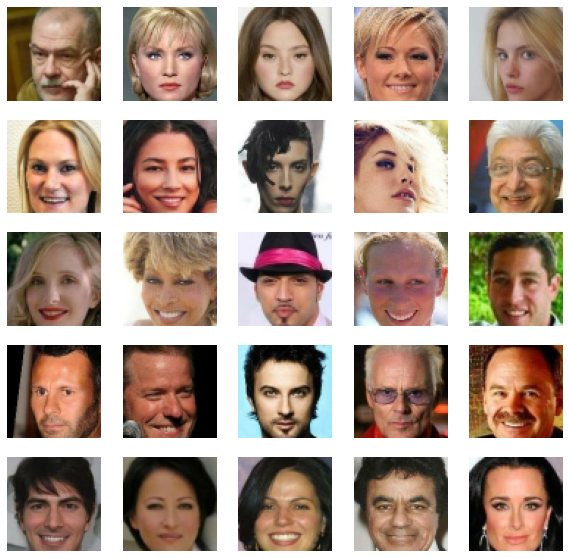

In [8]:
image_batch = next(iter(training_dataset))
show_batch(image_batch["encoder_input"].numpy())

## Network model
Here, we build the network model.

In [0]:
class Sampling(Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
def create_vae():
  # Define encoder model.
  input_img = Input(shape =(64, 64, 3), name='encoder_input')
  y = Input(shape =(40,), name='labels')

  x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu', name = 'encoder_conv_0')(input_img)
  x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu', name = 'encoder_conv_1')(x)
  x = Conv2D(filters = 128, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu', name = 'encoder_conv_2')(x)
  x = Conv2D(filters = 256, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu', name = 'encoder_conv_3')(x)

  shape_before_flattening = K.int_shape(x)[1:]

  x = Flatten()(x)

  z_mean = Dense(LATENT_DIM, name='z_mean')(x)
  z_log_var = Dense(LATENT_DIM, name='z_log_var')(x)


  # Define decoder
  z = Sampling()((z_mean, z_log_var))

  zy = Concatenate()([z,y])

  # To get an exact mirror image of the encoder
  dec_1 = Dense(np.prod(shape_before_flattening))
  dec_2 = Reshape(shape_before_flattening)
  dec_3 = Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu', name = 'decoder_conv_0')
  dec_4 = Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu', name = 'decoder_conv_1')
  dec_5 = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,  padding = 'same', activation = 'relu', name = 'decoder_conv_2')
  dec_6 = Conv2DTranspose(filters = 3, kernel_size = 3, strides = 2,  padding = 'same', activation = 'sigmoid', name = 'decoder_conv_3')

  dec1 = dec_1(zy)
  dec1 = dec_2(dec1)

  dec1 = dec_3(dec1)
  dec1 = dec_4(dec1)
  dec1 = dec_5(dec1)
  x_hat = dec_6(dec1)


  # Add KL divergence regularization loss.
  rec_loss =  12288 * tf.keras.losses.binary_crossentropy(Flatten()(input_img), Flatten()(x_hat))
  kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(rec_loss + kl_loss)

  vae = Model(inputs=[input_img, y], outputs=x_hat, name = "vae")
  vae.add_loss(vae_loss)

  noise = Input(shape=(LATENT_DIM,))
  label = Input(shape=(40,))
  xy = Concatenate()([noise, label])
  dec1 = dec_1(xy)
  dec1 = dec_2(dec1)

  dec1 = dec_3(dec1)
  dec1 = dec_4(dec1)
  dec1 = dec_5(dec1)
  x_hat = dec_6(dec1)

  generator = Model(inputs=[noise, label], outputs=x_hat)

  return vae, generator

vae, generator = create_vae()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer)

vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 16, 16, 64)   18496       encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_2 (Conv2D)         (None, 8, 8, 128)    73856       encoder_conv_1[0][0]             
________________________________________________________________________________________________

In [10]:
vae.fit(training_dataset, steps_per_epoch=202599//BATCH_SIZE, verbose = 1, epochs = 50)

Epoch 1/50
1582/1582 [==============================] - 92s 58ms/step - loss: 6804.0361
Epoch 2/50
1582/1582 [==============================] - 26s 16ms/step - loss: 6619.7075
Epoch 3/50
1582/1582 [==============================] - 26s 16ms/step - loss: 6599.9727
Epoch 4/50
1582/1582 [==============================] - 25s 16ms/step - loss: 6589.9404
Epoch 5/50
1582/1582 [==============================] - 25s 16ms/step - loss: 6584.2124
Epoch 6/50
1582/1582 [==============================] - 25s 16ms/step - loss: 6580.2559
Epoch 7/50
1582/1582 [==============================] - 25s 16ms/step - loss: 6577.0464
Epoch 8/50
1582/1582 [==============================] - 25s 16ms/step - loss: 6574.9595
Epoch 9/50
1582/1582 [==============================] - 25s 16ms/step - loss: 6572.3906
Epoch 10/50
1582/1582 [==============================] - 25s 16ms/step - loss: 6570.6201
Epoch 11/50
1582/1582 [==============================] - 25s 16ms/step - loss: 6567.9487
Epoch 12/50
1582/1582 [=======

In [0]:
vae.save_weights('vae.h5')
generator.save_weights('generator.h5')

In [0]:
vae.load_weights('vae.h5')
generator.load_weights('generator.h5')

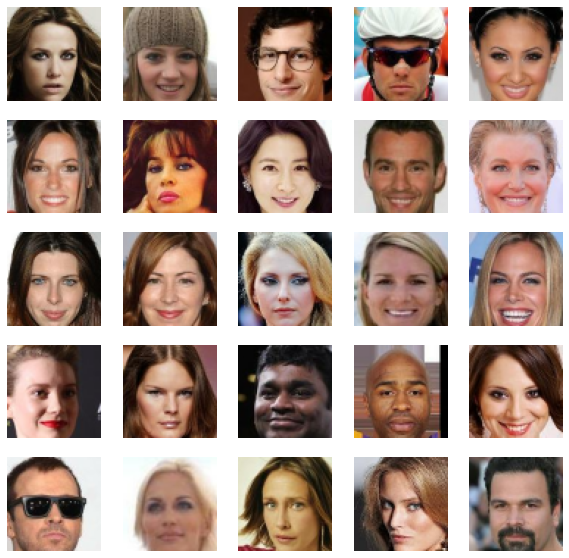

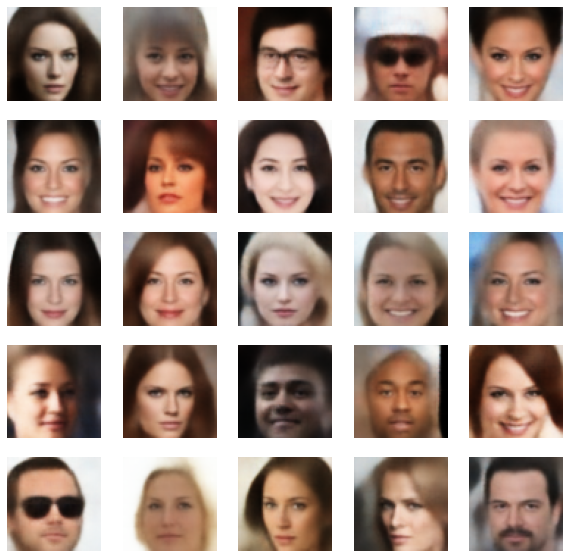

In [12]:
batch = next(iter(training_dataset))
show_batch(batch['encoder_input'].numpy())
predictions = vae.predict(batch, steps= 10)
show_batch(predictions)

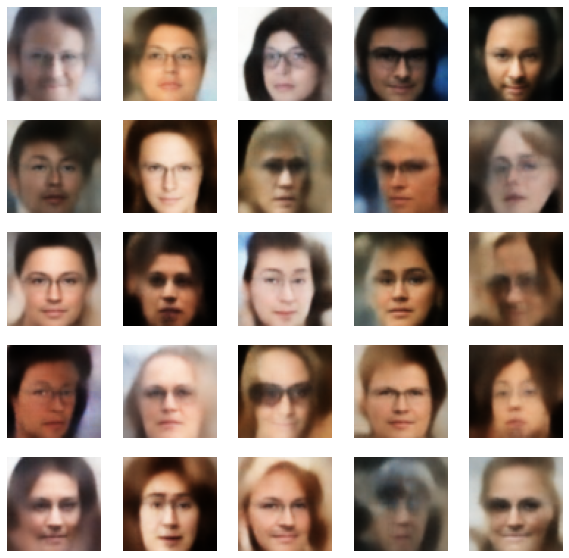

In [19]:
z_sample = np.random.normal(size=(25, LATENT_DIM))
label = np.zeros(shape=(25,ATTRIBUTES_SIZE))
label[:, 15] = 1
predictions = generator.predict([z_sample,label])
show_batch(predictions)

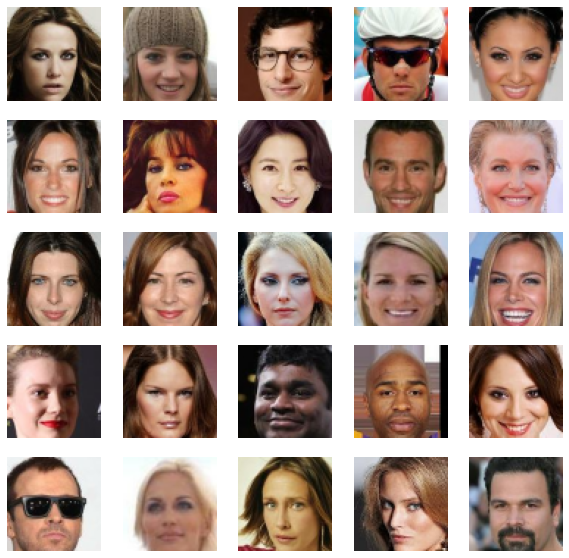

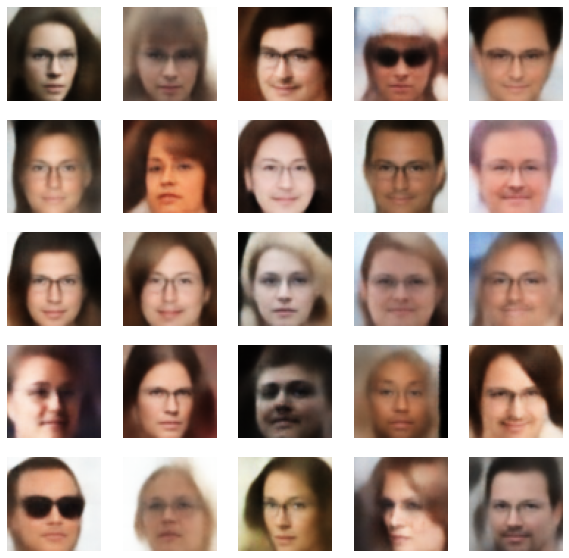

In [29]:
image_batch = batch['encoder_input'][:25].numpy()
show_batch(image_batch)
predictions = vae.predict([image_batch,label])
show_batch(predictions)